# Discounting Trends

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %load_ext autoreload
# the "1" means: always reload modules marked with "%aimport"
# %autoreload 1

#from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
import warnings
from sqlalchemy import create_engine
#from pivottablejs import pivot_ui


In [2]:
sns.set();
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_context("poster", font_scale=1.3)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

## Load Data

In [3]:
from decouple import config

In [19]:
#val = !cat '/home/jovyan/.env'
#db=val[0].split('=')[1];
db=config('DATABASE_URL')

In [20]:
engine = create_engine(db)

In [6]:
sql = '''
SELECT        

	t.FiscalMonth, 
	CAST (m.YearNum AS CHAR(4)) +'Q'+ CAST(m.QuarterNum AS CHAR(1)) AS year_qtr, 
	m.YearNum,  
	f.Branch, 
	i.SalesCategory, 
	t.OrderSourceCode, 
	t.PriceMethod, 
	c.SalesDivision, 
	c.SegCd, 
	SUM(t.ExtBase) AS ExtBase, 
	SUM(t.SalesAmt) AS SalesAmt, 
	SUM(t.ExtDiscLine) AS ExtDiscLine, 
	SUM(t.ExtDiscOrder) AS ExtDiscOrder, 
	SUM(t.ExtDiscAmt) AS ExtDiscAmt, 
	SUM(t.GPAmt) AS GPAmt

FROM            
	BRS_AGG_CMI_DW_Sales AS t 

	INNER JOIN BRS_FiscalMonth AS m 
	ON t.FiscalMonth = m.FiscalMonth 

	INNER JOIN BRS_Customer AS c 
	ON t.Shipto = c.ShipTo 

	INNER JOIN BRS_FSC_Rollup AS f 
	ON f.TerritoryCd = c.TerritoryCd

	INNER JOIN BRS_Item AS i 
	ON t.Item = i.Item 
	

WHERE         
	(t.SalesCategory = 'MERCH') AND 
	(t.FreeGoodsInvoicedInd = 0)  And 
--	(c.BillTo = 2613256) AND
    (f.Branch not in ('CORP', 'ZCORP')) AND
	(t.FiscalMonth BETWEEN 
		(Select [YearFirstFiscalMonth_HIST] FROM BRS_Rollup_Support01 ) and 
		(Select [PriorFiscalMonth] FROM BRS_Rollup_Support01 )
	)

GROUP BY 
	t.FiscalMonth, 
	m.YearNum, 
	m.QuarterNum, 
	f.Branch, 
	i.SalesCategory, 
	t.OrderSourceCode, 
	t.PriceMethod, 
	c.SalesDivision, 
	c.SegCd

'''

In [7]:
%time df = pd.read_sql_query(sql, engine);

CPU times: user 1.35 s, sys: 46 ms, total: 1.39 s
Wall time: 32.5 s


In [11]:
print (df.dtypes)
df.describe()


FiscalMonth          int64
year_qtr            object
YearNum              int64
Branch              object
SalesCategory       object
OrderSourceCode     object
PriceMethod         object
SalesDivision       object
SegCd               object
ExtBase            float64
SalesAmt           float64
ExtDiscLine        float64
ExtDiscOrder       float64
ExtDiscAmt         float64
GPAmt              float64
dtype: object


,FiscalMonth,YearNum,ExtBase,SalesAmt,ExtDiscLine,ExtDiscOrder,ExtDiscAmt,GPAmt
count,51689.000000,51689.000000,5.168900e+04,5.168900e+04,51689.000000,51689.000000,51689.000000,51689.000000
mean,201797.537078,2017.911819,1.690019e+04,1.448293e+04,2311.797913,105.462291,2417.260203,6286.371251
std,84.694579,0.853628,5.693113e+04,5.070153e+04,9123.431683,1646.345077,9482.692899,22992.906369
min,201612.000000,2016.000000,-6.147105e+04,-5.386229e+04,-43186.680000,-4821.040000,-43186.680000,-288696.000000
25%,201709.000000,2017.000000,3.998400e+02,3.309900e+02,24.980000,0.000000,25.200000,144.860000
50%,201805.000000,2018.000000,1.968100e+03,1.636050e+03,201.400000,0.000000,205.790000,707.320000
75%,201902.000000,2019.000000,9.122500e+03,7.675020e+03,1178.700000,0.000000,1215.580000,3250.600000
max,201910.000000,2019.000000,1.371641e+06,1.275585e+06,404630.110000,84481.650000,404630.110000,556215.690000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51689 entries, 0 to 51688
Data columns (total 15 columns):
FiscalMonth        51689 non-null int64
year_qtr           51689 non-null object
YearNum            51689 non-null int64
Branch             51689 non-null object
SalesCategory      51689 non-null object
OrderSourceCode    51689 non-null object
PriceMethod        51689 non-null object
SalesDivision      51689 non-null object
SegCd              51689 non-null object
ExtBase            51689 non-null float64
SalesAmt           51689 non-null float64
ExtDiscLine        51689 non-null float64
ExtDiscOrder       51689 non-null float64
ExtDiscAmt         51689 non-null float64
GPAmt              51689 non-null float64
dtypes: float64(6), int64(2), object(7)
memory usage: 5.9+ MB


## Trends

In [13]:
df.YearNum.unique()

array([2018, 2017, 2019, 2016])

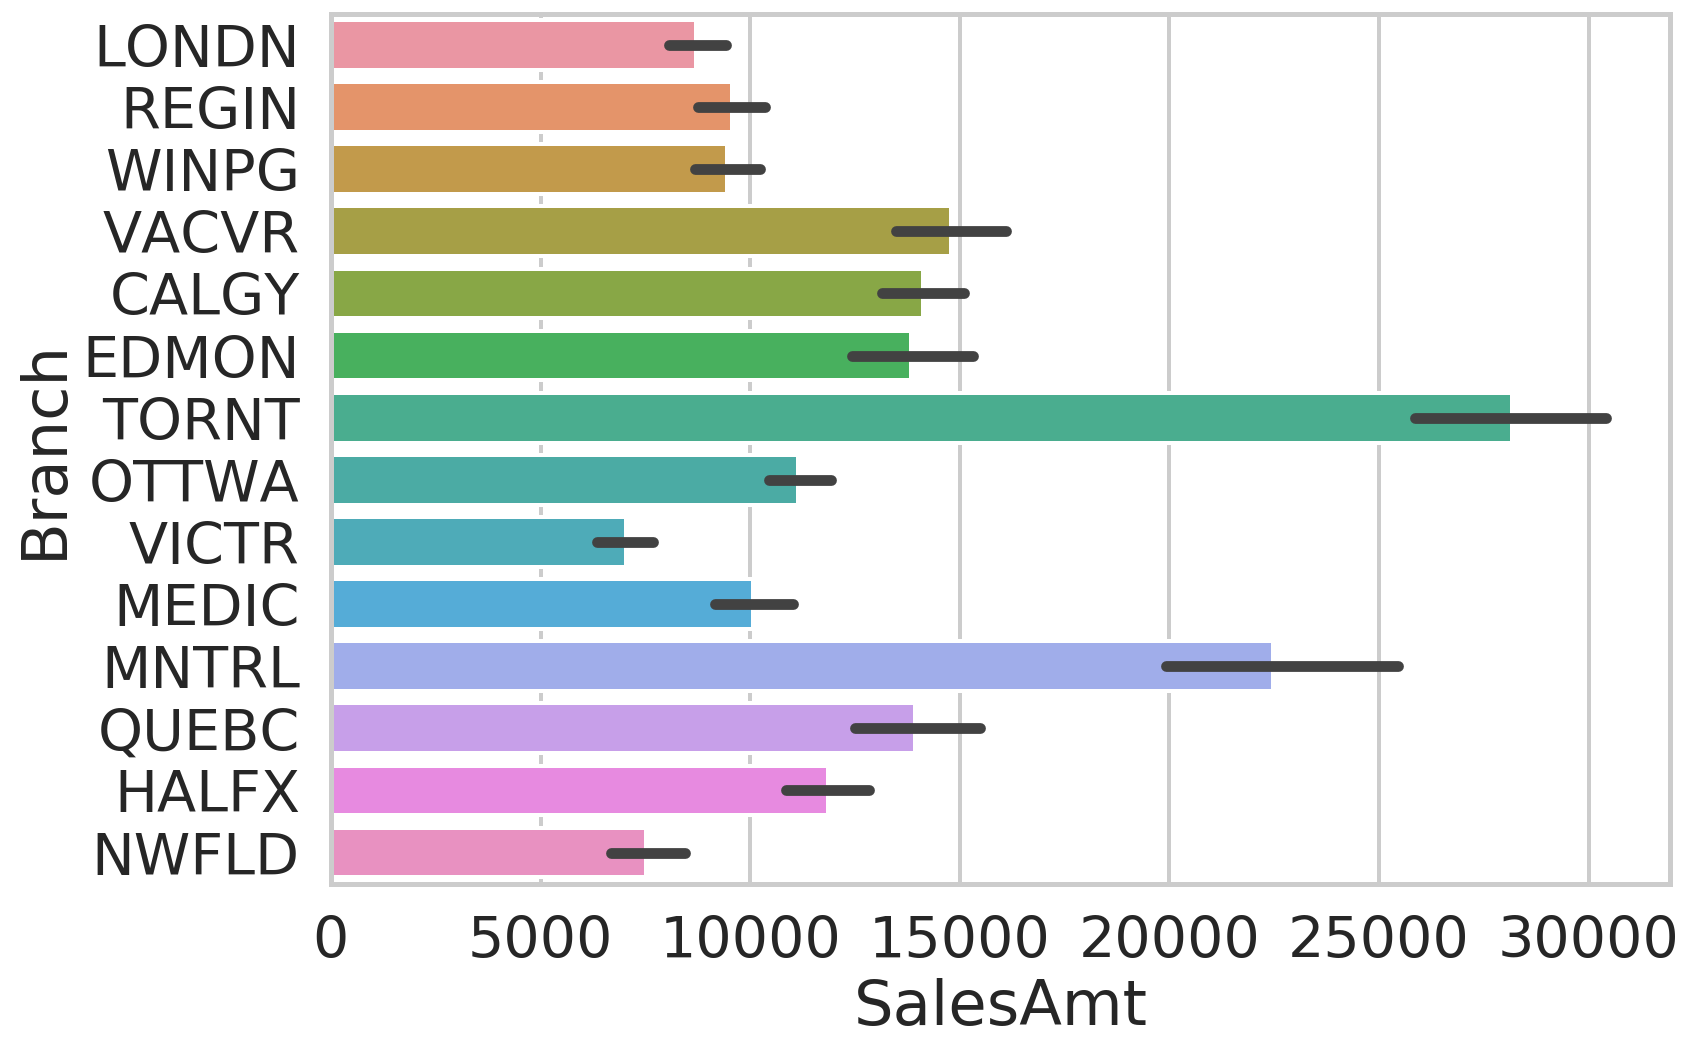

In [14]:
sns.barplot(data=df,x='SalesAmt',y='Branch',orient='h')

In [15]:
%time df2 = pd.read_sql_query('select * from BRS_Item', engine);

CPU times: user 8.56 s, sys: 333 ms, total: 8.89 s
Wall time: 8.9 s


In [35]:
df2.shape

(226680, 40)